In [117]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from utils import load_processed_data 
from plotting_utils import plot_confusion_matrix, plot_roc_curve

## 1. Load and Prepare Data

We'll use particle-level features from the jet data. See kaggle for a detailed description of the data. 

In [118]:
# Load data
# Create feature matrix and labels

X_train, y_train, train_ids, X_val, y_val, val_ids, X_test, test_ids= load_processed_data()

X_train.shape 


(3520, 14)

In [119]:
# Define columns to drop
cols_to_drop = ['cluster_size_ratio','std_cluster_size','max_cluster_size','mean_cluster_size','max_cluster_pt', 'total_pt','max_cluster_eta']
# Drop from training and validation sets
X_train = X_train.drop(columns=cols_to_drop, errors='ignore')
X_val = X_val.drop(columns=cols_to_drop, errors='ignore')

In [120]:
# # Drop the last 5 specific columns by name
# X_train = X_train.drop(
#     ['max_cluster_phi', 'mean_cluster_eta', 'mean_cluster_phi', 'cluster_pt_ratio', 'cluster_size_ratio'],
#     axis=1
# )

# # Optional: Check to confirm they were removed
# print(X_train.columns)


In [121]:
X_train.head()  

,n_clusters,mean_cluster_pt,std_cluster_pt,max_cluster_phi,mean_cluster_eta,mean_cluster_phi,cluster_pt_ratio
0,13,0.615318,0.539951,0.7,0.076923,0.346154,1.470200
1,10,0.777020,0.601157,0.5,0.100000,0.230000,1.430785
2,4,0.972718,0.606990,0.1,0.050000,0.050000,2.557882
3,14,0.746367,0.485636,0.5,0.185714,0.285714,1.624096
4,6,0.575760,0.639069,0.1,0.050000,0.066667,4.988196


## 2. Train XGBoost Model

XGBoost has several important hyperparameters:
- `n_estimators`: How many trees to we use 
- `max_depth`: How deep is each tree - i.e. how many decisions does it make. Can you see a reason why we might want to set a max here? 
- `learning_rate`: How big is our gradient step 
- `objective`: Learning task and objective function - since we can do classification or regression it's important to select the right one here. 

In [122]:
# Initialize and train model
model = xgb.XGBClassifier(
    n_estimators=10,  # Number of boosting rounds
    max_depth=10000,      # Maximum tree depth
    learning_rate=0.1, # Step size shrinkage
    objective='binary:logistic',  # Binary classification
    random_state=42
)

# Train the model
model.fit(X_train, y_train,
          eval_set=[(X_val, y_val)],
          verbose=True)

[0]	validation_0-logloss:0.58169
[1]	validation_0-logloss:0.53342
[2]	validation_0-logloss:0.49599
[3]	validation_0-logloss:0.46600
[4]	validation_0-logloss:0.43831
[5]	validation_0-logloss:0.41607
[6]	validation_0-logloss:0.39760
[7]	validation_0-logloss:0.38205
[8]	validation_0-logloss:0.36694
[9]	validation_0-logloss:0.35429


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10000, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=10, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

## 3. Evaluate Model

Let's evaluate our model using:
- Accuracy: Overall prediction accuracy
- Confusion Matrix: This is common for classifications. How often did we classify or misclassify each category? It's common that some categories are harder than others. 

Test Accuracy: 0.8705


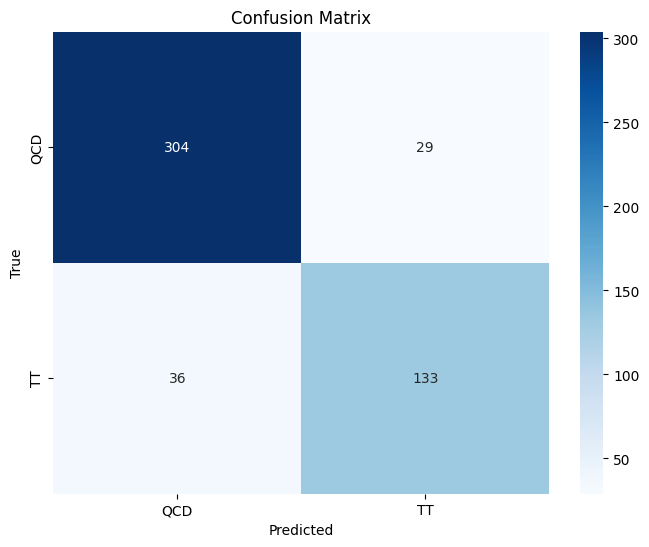

In [123]:
# Make predictions

# this gives us probabilities for both categories - we only want for ttbar, so we select one column
# with a binary classification, the probability for one category implies the other 
y_pred = model.predict_proba(X_val)[:, 1]

# to test accuracy and confusion matrix, we need labels 0 and 1, so we set that based on a threshold
discrete_pred = np.where(y_pred > 0.5, 1, 0)
# Calculate accuracy
accuracy = accuracy_score(y_val, np.where(y_pred > 0.5, 1, 0))
print(f"Test Accuracy: {accuracy:.4f}")

# Plot confusion matrix
plot_confusion_matrix(y_val, discrete_pred)

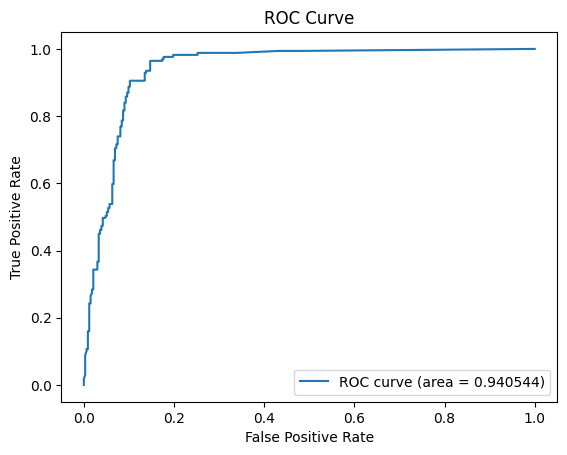

In [124]:
plot_roc_curve(y_val, y_pred)

## 4. Feature Importance Analysis

One of the advantages of BDTs is that they provide feature importance scores, which help us understand which features are most important for the classification task. Beware that this doesn't translate directly to which are the best features in the data - only to what the model thinks. So if you have a bad model, your feature importance will be equally useless. Another model could also pick up on features that the BDT didn't, so it's only an indicator. 

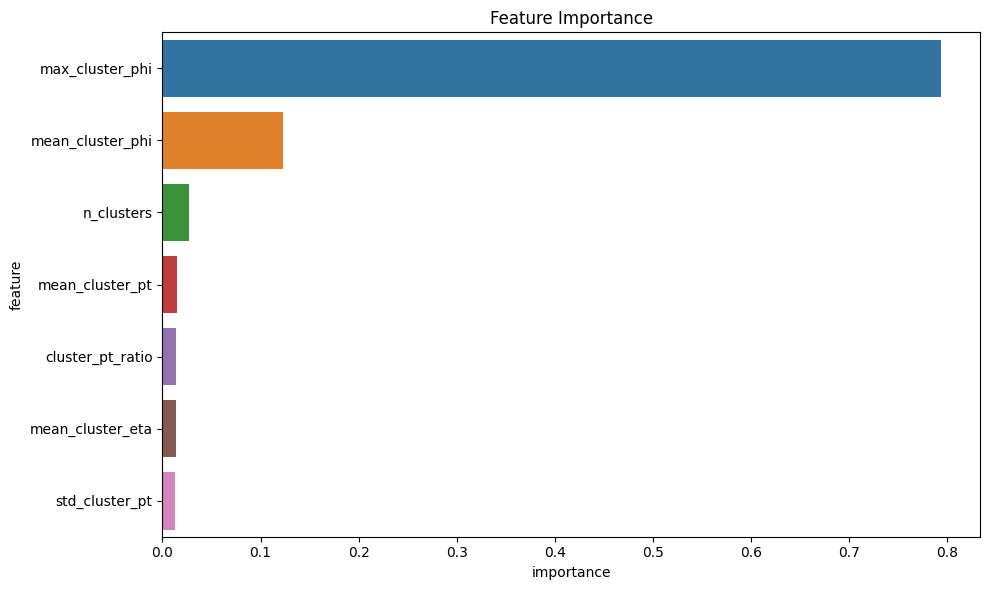

In [125]:
# Plot feature importance
importance = model.feature_importances_
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': importance
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Feature Importance')
plt.tight_layout() 
plt.show()

# 5 - Make kaggle predictions¶


In [126]:
test_predictions = model.predict_proba(X_test)[:, 1]
solution = pd.DataFrame({'id':test_ids, 'label':test_predictions})
solution.to_csv('submission.csv', index=False)

ValueError: feature_names mismatch: ['n_clusters', 'mean_cluster_pt', 'std_cluster_pt', 'max_cluster_phi', 'mean_cluster_eta', 'mean_cluster_phi', 'cluster_pt_ratio'] ['n_clusters', 'max_cluster_pt', 'mean_cluster_pt', 'std_cluster_pt', 'max_cluster_size', 'mean_cluster_size', 'std_cluster_size', 'total_pt', 'max_cluster_eta', 'max_cluster_phi', 'mean_cluster_eta', 'mean_cluster_phi', 'cluster_pt_ratio', 'cluster_size_ratio']
training data did not have the following fields: max_cluster_size, std_cluster_size, mean_cluster_size, max_cluster_pt, total_pt, max_cluster_eta, cluster_size_ratio